In [2]:
% matplotlib inline
import pandas as pd
import numpy as np
from scipy.stats import entropy
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [3]:
def pca(points, xref, yref):
    data = points.T
    pca = PCA()   #保留所有成分
    pca.fit(data)
    # print(pca.explained_variance_ratio_)
    k = pca.components_[0, 1] / pca.components_[0, 0]
    b = np.mean(yref + points[1]) + 1 / k * (xref + np.mean(points[0]))
    # print(np.mean(yref + points[1]), xref + np.mean(points[0]), k, b)
    if pca.explained_variance_ratio_[0] > 0.99: # 第一主成分大于0.98
        return k, b
    else:
        return 0, 0
def threshold(img, percentage = None, num = None):
    """
        阈值化
        方法：根据灰度分布直方图，找到窗口中最亮的若干点
    """
    if num is None and percentage is not None:
        num = img.size * percentage
    if num is None and percentage is None:
        num = img.size * 0.1
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    cnt = 0
    th = 0
    for k in range(256):
        cnt = cnt + hist[255 - k]
        if cnt > num:
            th = 255 - k - 1
            break
    ret, thImg = cv2.threshold(img,th,255,cv2.THRESH_BINARY)
    return thImg
def Kernel(size, width, theta):
    """
        构造卷积核
        
    参数：size：卷积核尺寸
          width：正区域宽度
          theta：角度
    注：(size - width)最好是偶数，以使得卷积核对称
    """
    temp = np.zeros((size + 10,size + 10))
    temp [(size - width) // 2 + 5:(size - width) // 2 + 5 + width,:] = 1
    temp = Image.fromarray(temp)
    temp = temp.rotate(theta)
    temp = np.array(temp)
    kernel = temp[5:-5, 5:-5]
    cnt = np.sum(kernel)
    for i in range(size):
        for j in range(size):
            kernel[i, j] = cnt / (cnt - size * size) if kernel[i, j] == 0 else kernel[i, j]
    kernel = kernel / 4
    return kernel
def Cluster(coordins):
    data = coordins.T
    pred = DBSCAN(eps = 20, min_samples = 5).fit_predict(data)
    groups = []
    for i in np.unique(pred):
        cnt = list(pred).count(i)
        if cnt > 0.9 * pred.size:
            groups.append(coordins[:, np.where(pred == i)].squeeze(1))
    # plt.figure()
    # plt.scatter(data[:, 0], data[:, 1], c = pred)
    # plt.show()
    return groups
def filter():
    pass
def Direction_estimate(image):
    row, col = image.shape
    win = 100
    Theta = list([])
    for i in range(row // win):
        for j in range(col // win):
            drawImg = np.zeros((win, win))
            window = image[i * win : (i + 1) * win, j * win : (j + 1) * win]
            mean = np.mean(window)
            if mean > 180:
                continue
            thImg = threshold(window, num = 50)
            points = np.array(np.where(thImg == 255))
            # print(points)
            stdx = np.std(points[0])
            stdy = np.std(points[1])
            if stdx + stdy > 50:
                continue
            # plt.figure()
            # plt.imshow(thImg, cmap = 'gray')
            coordins = np.vstack((points[1], win - 1 - points[0]))
            groups = Cluster(coordins)
            for group in groups:
                # print(group)
                theta = pca(group, win * j, src.shape[0] - win * (i + 1))
                if theta != (0, 0):
                    Theta.append(theta)
                    # plt.figure()
                    # plt.imshow(thImg, cmap = 'gray')
    std = np.std(np.array(Theta)[:, 0])
    if std > 1:  # 如果各个点的角度方差较大，则旋转轴靠近Z轴
        Theta = np.array(Theta)
        A = - np.ones_like(Theta[1:3])
        A[:2, 0] = - 1 / Theta[1:3, 0]
        b = - Theta[1:3, 1]
        A_ = np.linalg.inv(np.dot(A.T, A)).dot(A.T).dot(b)
        plt.figure()
        plt.imshow(src, cmap = 'gray')
        plt.scatter(A_[0], src.shape[0] - A_[1], color = 'r')
        plt.show()
        return [A_[0], src.shape[0] - A_[1]]
    else:
        return [np.mean(np.array(Theta)[:, 0])]
    

In [4]:
Kernels = []
for theta in range(-90, 91):
    Kernels.append(Kernel(11, 3, theta))
def mConv(src, center):
    print(center[0], center[1])
    # center[1] = src.shape[0] - center[1]
    ret = np.zeros_like(src)
    for row in range(6 , (src.shape[0] - 5)):
        for col in range(6 , (src.shape[1] - 5)):
            row = src.shape[0] - row - 1
            kernel = Kernels[(np.arctan((col - center[0])/(row - center[1])) * 180 / np.pi).astype(np.int).item() + 90]
            conv = np.sum(kernel * src[row - 5:row + 6, col - 5:col + 6])
            ret[row, col] = conv if conv >= 0 else 0
            # print((np.arctan((row - center[0])/(col - center[1])) * 180 / np.pi))
            # return ret
            # print(kernel, src[row - 5:row + 6, col - 5:col + 6], ret[row, col])
    return ret

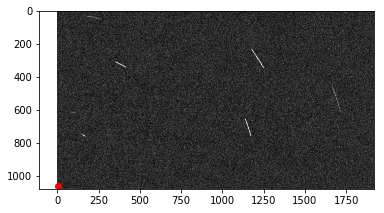

2
[4.0985328006198074, 1064.2508131787959]
4.09853280062 1064.25081318


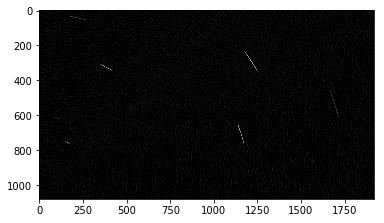

In [5]:
if __name__ == '__main__':
    src = cv2.imread('sssd1.png', 0)
    blured = cv2.blur(src, (3, 3))
    directions =  Direction_estimate(blured);
    print(len(directions))
    if len(directions) == 1:
        print(np.arctan(directions) * 180 / np.pi)
        kernel = Kernels[(np.arctan(directions) * 180 / np.pi).astype(np.int).item() + 90]
        plt.imshow(kernel, cmap = 'gray')
        print(src.shape)
        ret = cv2.filter2D(src, -1, kernel)
        print(ret.shape)
    else:
        print(directions)
        ret = mConv(src, directions)
        plt.imshow(ret, cmap = 'gray')
    thImg = threshold(ret, percentage = 0.01)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    thImg = cv2.morphologyEx(thImg, cv2.MORPH_OPEN, k)
    contours, hierarchy = cv2.findContours(thImg,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE) 

In [6]:
cv2.imwrite('ret.png', ret)
cv2.imwrite('th.png', thImg)

True

In [7]:
ret[:10, :10]

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  2,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  6,  6,  5,  3],
       [ 0,  0,  0,  0,  0,  0,  9, 11, 11,  9]], dtype=uint8)

In [8]:
def drawContour(cImg, star_contour):
    for contour in star_contour:
        cImg[[contour[:, 1], contour[:, 0]]] = 255

(62, 2)


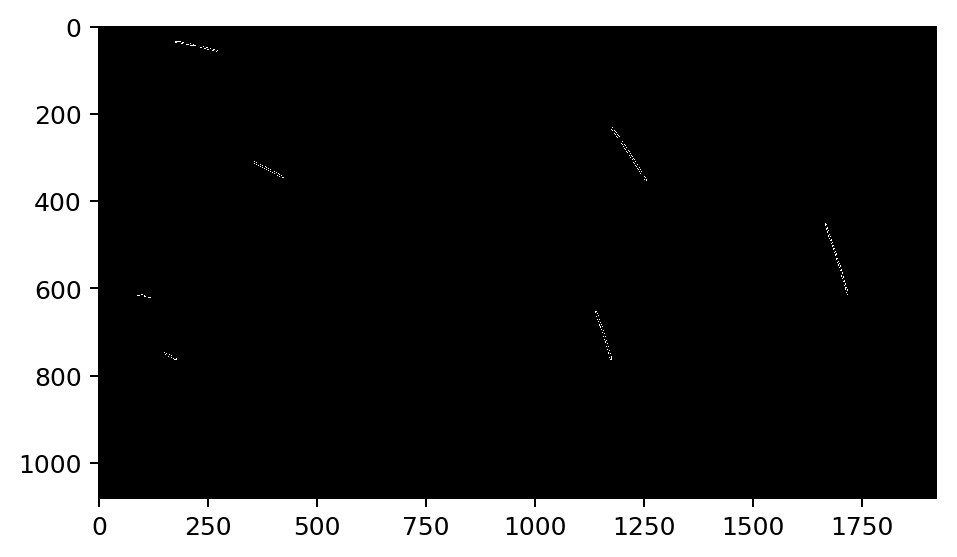

In [9]:
img = np.zeros_like(src)
contour_list = []
for contour in contours:
    # print(cv.contourArea(contour), contour.shape[0])
    if contour.shape[0] > 50:
        contour_list.append(contour.squeeze(1))
print(contour_list[0].shape)
drawContour(img, contour_list)
plt.figure(dpi = 180)
plt.imshow(img, cmap = 'gray')
